In [1]:
import numpy as np
import os
import time

from functions.evaluation import Evaluation
from functions.plotting import Plotting
from functions.utilities import Utilities
from functions.tuning import Tuning

import torch

%matplotlib inline

In [2]:
# Hyperparameters
BATCH_SIZES = [64, 32]
CLASS_NUM = 6
EPOCHS = 10000
FILE_PATH = "dataset/resized"
HIDDEN_LAYER_SIZES = [[512, 256], [512, 512], [1024, 512], [1024, 1024], 
                      [1024], [512], [1024, 512, 256]]
K_PREDS = 3
LEARNING_RATE = 0.001
SPLIT_SIZE = 0.15
SEED = 1

In [3]:
# Instantiate classes
utils = Utilities()
plotting = Plotting()
evaluate = Evaluation()
tuning = Tuning()

Device set to GPU.
Device set to GPU.


In [4]:
dataset = utils.augment_data(FILE_PATH)
class_labels = np.array(list(dataset.class_to_idx), dtype = object)

In [5]:
# Get list of trained model file paths
cwd = os.getcwd()
cwd += "\\models"
model_file_paths = os.listdir(cwd)

In [6]:
model_stats = []
counter = 1
model_num = len(BATCH_SIZES) * len(HIDDEN_LAYER_SIZES)
start_time = time.time()

for name_path in model_file_paths:
    if "inception" in name_path:
        load_file_path = f"models/{name_path}"
        name = name_path.split(".")[0] # remove .pt
        _, batch = name.split("_")[:2]
        hidden_layers = list(map(int, name.split("_")[2:]))
        
        print(f"({counter}/{model_num}) Loading model '{name}'-", end=" ")
        model = tuning.create_model(CLASS_NUM, hidden_layers)
        _, test_loader, _, _ = utils.split_data(dataset, int(batch), SPLIT_SIZE, SEED)
        train_losses, valid_losses = utils.load_model(model, load_file_path)
        print("\tEvaluating performance metrics -", end=" ")
        metrics = evaluate.test_model(model, name, test_loader, K_PREDS)
        model_stats.append(metrics)
        counter += 1
        print("Complete.")
utils.time_taken(time.time() - start_time)

(1/14) Loading model 'inception_32_1024'- Model loaded.
	Evaluating performance metrics - Complete.
(2/14) Loading model 'inception_32_1024_1024'- Model loaded.
	Evaluating performance metrics - Complete.
(3/14) Loading model 'inception_32_1024_512'- Model loaded.
	Evaluating performance metrics - Complete.
(4/14) Loading model 'inception_32_1024_512_256'- Model loaded.
	Evaluating performance metrics - Complete.
(5/14) Loading model 'inception_32_512'- Model loaded.
	Evaluating performance metrics - Complete.
(6/14) Loading model 'inception_32_512_256'- Model loaded.
	Evaluating performance metrics - Complete.
(7/14) Loading model 'inception_32_512_512'- Model loaded.
	Evaluating performance metrics - Complete.
(8/14) Loading model 'inception_64_1024'- Model loaded.
	Evaluating performance metrics - Complete.
(9/14) Loading model 'inception_64_1024_1024'- Model loaded.
	Evaluating performance metrics - Complete.
(10/14) Loading model 'inception_64_1024_512'- Model loaded.
	Evaluating 

In [7]:
all_stats = plotting.stats_table(model_stats)
all_stats.style.hide_index()

Name,Accuracy,Top 1 Error,Top 3 Error,Precision,Recall,F1 Score
inception_32_1024,0.875000,0.125000,0.031250,1.000000,0.965517,0.982456
inception_32_1024_1024,0.906250,0.093750,0.000000,0.966667,0.966667,0.966667
inception_32_1024_512,0.906250,0.093750,0.000000,0.966667,1.000000,0.983051
inception_32_1024_512_256,0.875000,0.125000,0.000000,0.965517,1.000000,0.982456
inception_32_512,0.937500,0.062500,0.031250,1.000000,0.967742,0.983607
inception_32_512_256,0.875000,0.125000,0.000000,0.965517,0.965517,0.965517
inception_32_512_512,0.875000,0.125000,0.031250,1.000000,1.000000,1.000000
inception_64_1024,0.906250,0.093750,0.015625,0.983051,1.000000,0.991453
inception_64_1024_1024,0.921875,0.078125,0.015625,0.983333,1.000000,0.991597
inception_64_1024_512,0.906250,0.093750,0.015625,1.000000,1.000000,1.000000


In [8]:
# Get best model stats
idx = all_stats['Accuracy'].idxmax()
best_model = all_stats.iloc[idx, :]
best_model_stats = plotting.stats_table([best_model])
best_model_stats.style.hide_index()

Name,Accuracy,Top 1 Error,Top 3 Error,Precision,Recall,F1 Score
inception_32_512,0.937500,0.062500,0.031250,1.000000,0.967742,0.983607


In [9]:
best_model_name, best_hidden_sizes = tuning.save_best_model(best_model_stats, CLASS_NUM)

Model saved - Name: 'inception_32_512' | Hidden layer sizes: '[512]'


In [10]:
best_model_path = f"models/best_model"
for size in best_hidden_sizes:
    best_model_path += f"_{size}"
best_model_path += ".pt"

inception = tuning.create_model(CLASS_NUM, best_hidden_sizes)
model_name, metrics, train_losses, valid_losses = tuning.load_best_model(inception, best_model_path)

Model loaded. Name: 'inception_32_512'


In [11]:
batch = model_name.split("_")[1]
_, test_loader, _, _ = utils.split_data(dataset, int(batch), SPLIT_SIZE, SEED)
probabilities, labels, predictions = tuning.get_model_data(inception, test_loader)

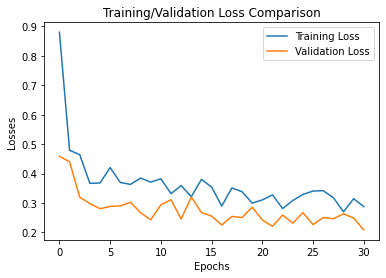

In [12]:
plotting.plot_losses(train_losses, valid_losses)

['black_bear' 'brown_bear' 'cougar' 'coyote' 'polar_bear' 'wolf']


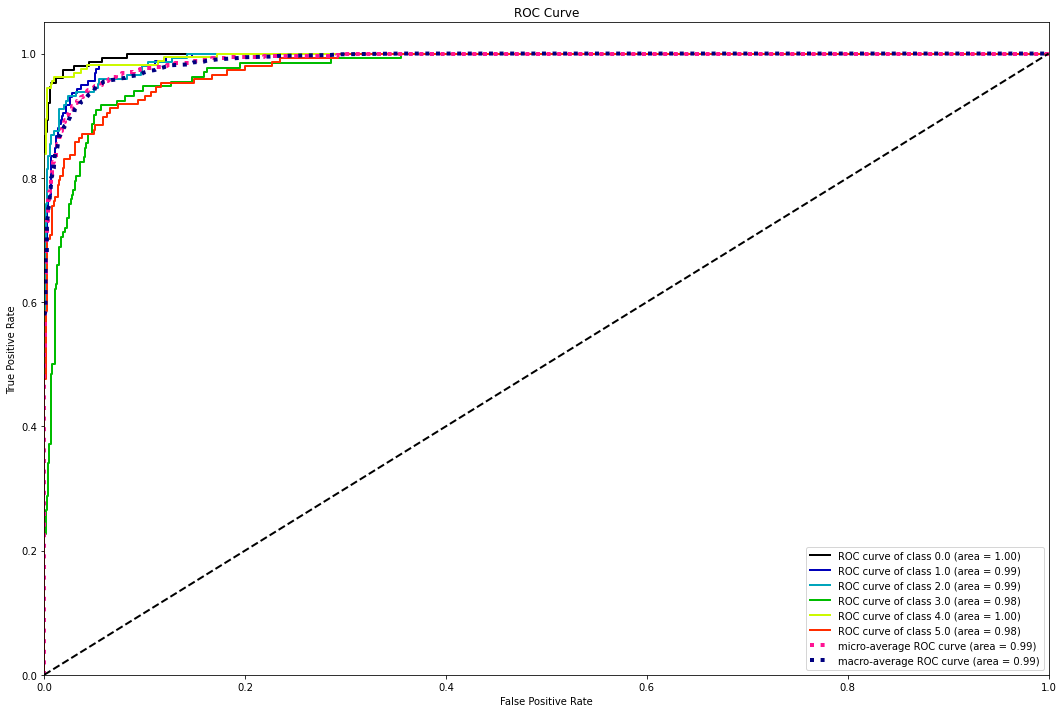

In [15]:
# Plot ROC curves
print(class_labels)
plotting.plot_roc_curve(inception, probabilities, labels, figsize=(18, 12))

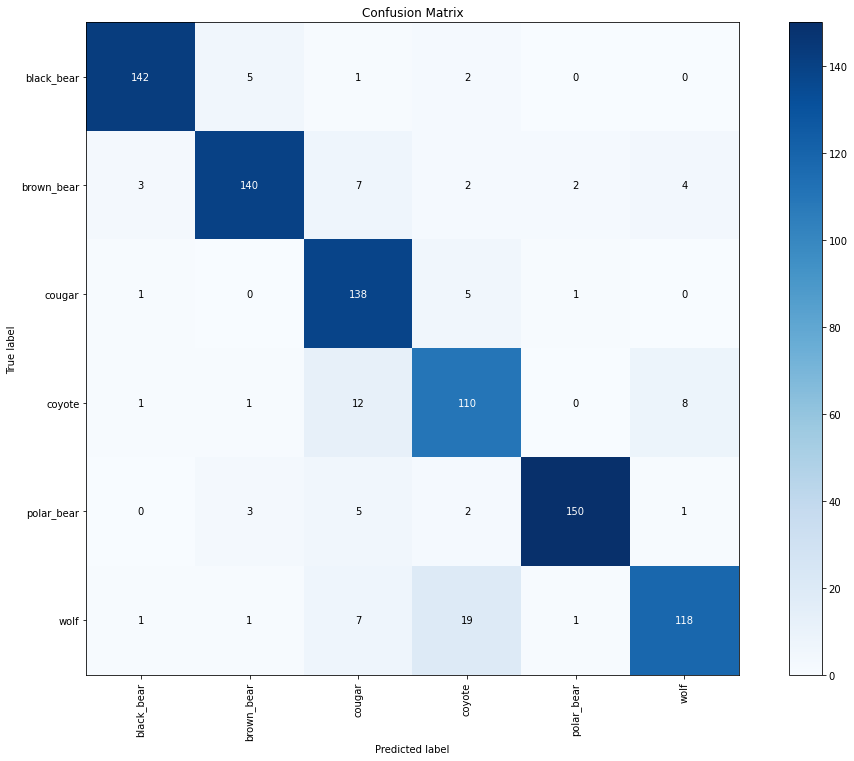

In [14]:
# Plot Confusion Matrices
pred_indices, label_indices = tuning.indices_to_labels(predictions, labels, class_labels)
plotting.plot_cm(inception, pred_indices, label_indices, class_labels, figsize=(18, 12))